In [1]:
from lightkurve import search_targetpixelfile
pixelfile = search_targetpixelfile("KIC 8462852", quarter=16).download();

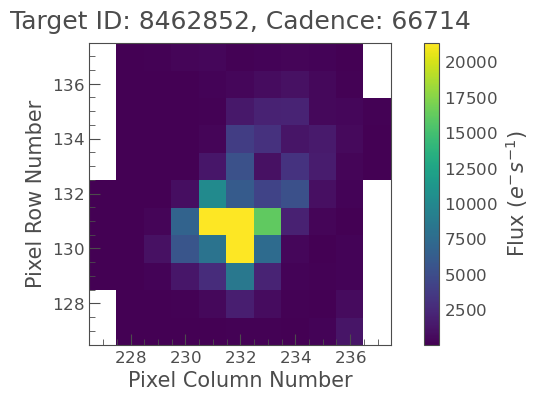

In [2]:
pixelfile.plot(frame=1);

In [3]:
lc = pixelfile.to_lightcurve(aperture_mask='all')

In [4]:
lc.time.mjd[0]

56304.61777934497

In [5]:
lc.flux.value[0]

258645.03

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

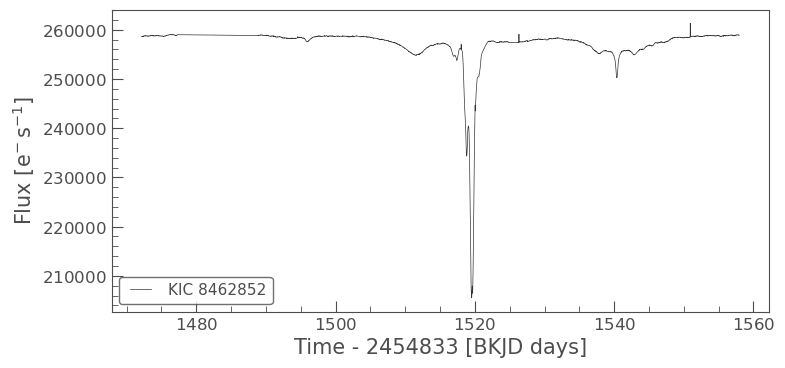

In [6]:
lc.plot()

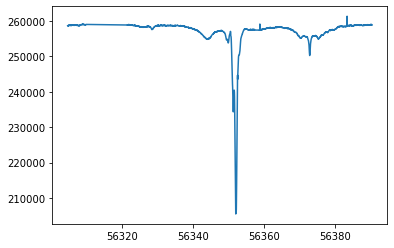

In [7]:
import matplotlib.pyplot as plt
plt.plot(lc.time.mjd,lc.flux.value)

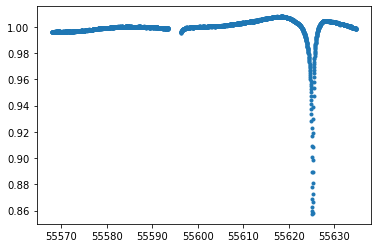

55567.88410553058 55634.84423949989


In [23]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import math

searchResult = lk.search_lightcurve("KIC 8462852", quarter = 8)
lc = searchResult.download()
times = lc.time.mjd
flux = lc.flux.value
medFlux = np.nanmedian(flux)
flux = flux/medFlux
fluxErr = lc.flux_err.value
fluxErr = fluxErr/medFlux
for i in range(len(flux)):
    if i == len(flux):
        break
    if not(flux[i] > 1) and (not(flux[i] < 1)):
        flux = np.delete(flux,i)
        times = np.delete(times,i)
        fluxErr = np.delete(fluxErr,i)



fig = plt.subplot()
fig.plot(times, flux, ls = '', marker = '.')
plt.show()
 

print(np.min(times), np.max(times))

In [9]:
for f in flux:
    if f == math.nan:
        print("NaN")

In [10]:
def generateEllipse(a,b,centerX,centerY, grid, opacity):
    '''
    Creates a two dimensional array with an ellipse filled in
    Parameters:
    a: The width of the ellipse
    b: The height of the ellipse
    centerX: The x coordinate of the center of the ellipse, must be larger than a
    centerY: The y coordinate of the center of the ellipse, mast be larger than b
    grid: The two dimennsional array to generate the ellipse on, must be larger than [centerX + a][centerY + b]
    opacity: Value to give the filled in values of the ellipse

    Returns:
    grid: the filled in grid with an ellipse
    '''
    for x in range(len(grid)):
        for y in range(len(grid[0])):
            if a > 0 and b > 0:
                if ((x-centerX)/a)*((x-centerX)/a) + ((y-centerY)/b)*((y-centerY)/b) <= 1:
                    grid[x][y] = opacity
    
    return grid

def transitSim(a,b,r, speed, times, tref, opacity):
    '''
    Creates a light curve of a transiting ellipse from the paramters
    Parameters:
    a: The width of the ellipse
    b: The height of the ellipse
    r: The radius of the star
    speed: The speed at which the ellipse transits (in stellar radii per unit time)
    times: A list of time points to generate a value for
    tref: The location of the center of the transit in the time array by value
    opacity: The opacity of the ellipse, although there is no technical limit for this value, the physical limit is [0,1] 
    '''
    ##Calculate the dimension ratios incase the ellipse has to be resized
    ab = a/b
    br = b/r
    
    tmin = tref - 1/(2*speed) ##Calculate the lower time bound for the transit
    tmax = tref + 1/(2*speed) ##Calculate the upper time bound for the transit
    transitTimes = [t for t in times if t >= tmin and t <= tmax] ##Create an array of only the times included in the transit
    flux = [1 for t in times if t < tmin] ##Create an array of the flux values, setting it to 1 before the transit
    differences = [] ##Calculate the differences between the time points
    for i in range(1,len(transitTimes)):
        differences.append(transitTimes[i] - transitTimes[i-1])
    
    minDiff = np.min(differences)
    intDiffs = [int(d/minDiff) for d in differences]##Normalize the difference so the smallest one has value unity
    length = np.sum(intDiffs)##Calculate the length of the transit in steps
    
    
    res = int((2*(b+r))/length) ##Resize the dimensions so the length matches what is required for the time array
    if res < 1:
        res = 1
    rnew = int(res*length/(2*(1+br)))
    bnew = int(br*rnew)
    anew = int(ab*bnew)
    newIntDiffs = [res*i for i in intDiffs]
    
    starGrid = np.zeros([2*rnew, 4*bnew+2*rnew+4])
    ellipseGrid = np.zeros([2*rnew, 4*bnew+2*rnew+4])
    starGrid = generateEllipse(rnew,rnew,rnew, 2*bnew+rnew, starGrid,1)##Generate the star
    ellipseGrid = generateEllipse(anew,bnew,rnew,3*bnew+2*rnew + 2,ellipseGrid,opacity)##Genrate the occulter
    planetGrid = np.ones([2*rnew,4*bnew+2*rnew+ 4]) - ellipseGrid
    fluxGrid = np.multiply(starGrid,planetGrid)##Calculate the flux by item by item multiplying each pixel in the star and planet grid and summing
    initialFlux = np.sum(fluxGrid)
    
    for i in newIntDiffs:
        for j in range(i):
            planetGrid = np.delete(planetGrid,0,1)
            planetGrid = np.append(planetGrid,np.ones([2*rnew,1]),1)##Move the first column to the end to "move" the planet across the star
            
        
        fluxGrid = np.multiply(starGrid,planetGrid)
        percentFlux = np.sum(fluxGrid)/initialFlux
        flux.append(percentFlux)#Calculate a normalized value of flux
        
    for t in times:
        if t > tmax:
            flux.append(1)##Add full flux after the transit
    
    flux.append(1)
    return flux

In [21]:
def logLikelihood(theta, times, flux, fluxErr):
    """
    Calculates the log likelihood based on the difference between the model and the data

    Args:
        theta (list) - parameters of the model
        times (list) - time array of the light curve
        flux (list) - array of flux data points
        fluxErr (list) - array of errors for the flux data points

    Returns:
        lnl (float) - log likelihood for the given theta values
    """
    xdim, ydim, velocity, tRef, opacity = theta
    fluxPredicted = transitSim(xdim, ydim,50,velocity,times, tRef,opacity)
    error = [((flux[i] - fluxPredicted[i])**2) /(2*fluxErr[i]**2) for i in range(len(flux))]
    lnl = -np.sum(error)
    return lnl

In [12]:
lnl = logLikelihood([30,30,0.2,55625,0.8],times,flux,fluxErr)
for i in lnl:
    if not(i > 1) and not(i < 1):
        print(i)


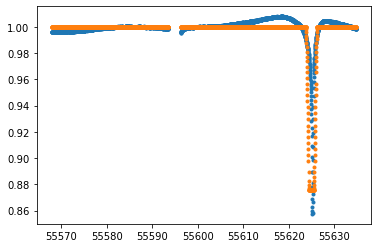

In [19]:
earchResult = lk.search_lightcurve("KIC 8462852", quarter = 8)
lc = searchResult.download()
times = lc.time.mjd
flux = lc.flux.value
medFlux = np.nanmedian(flux)
flux = flux/medFlux
fluxErr = lc.flux_err.value
for i in range(len(flux)):
    if i == len(flux):
        break
    if not(flux[i] > 1) and (not(flux[i] < 1)):
        flux = np.delete(flux,i)
        times = np.delete(times,i)
        fluxErr = np.delete(fluxErr,i)

modelFlux = transitSim(20,20,50,0.4,times,55625,0.8)

fig = plt.subplot()
fig.plot(times, flux, ls = '', marker = '.')
fig.plot(times, modelFlux, ls = '', marker = '.')
plt.show()

In [25]:
lnl = logLikelihood([20,20,0.4,55625,0.8],times,flux,fluxErr)
print(lnl)

-62395991.7376209
